In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, learning_curve
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, f1_score, roc_auc_score

In [32]:
labels = pd.read_csv('./../../labels/labels_v4/labels_v4.csv', index_col=0)
features = pd.read_csv('./../../models/model_logistic_regression_v5/manually_selected_features_frac.csv', index_col=0)

print(list(features))

['BRCA1/2_mut', 'other_HRR_gene_mutation_somatic', 'sv_trans_frac', 'sv_del_frac', 'sv_inv_frac', 'sv_tadem_dup_frac', 'sv_n_all_sv', 'sv_n_svclass_stdev', 'sv_microhom_deletion_mean', 'sv_microhom_inversion_mean', 'sv_microhom_tandem-duplication_mean', 'sv_microhom_translocation_mean', 'indel_n_del', 'indel_n_ins', 'ins_indel_ratio', 'del_indel_ratio', 'indel_DEL_len_1', 'indel_DEL_len_2', 'indel_DEL_len_3', 'indel_DEL_len_4', 'indel_DEL_len_inf', 'indel_INS_len_1', 'indel_INS_len_2', 'indel_INS_len_3', 'indel_INS_len_4', 'indel_INS_len_inf', 'indel_DEL_mh', 'indel_DEL_noMHstatus', 'indel_DEL_rep', 'indel_del_mh_ratio', 'Telomeric_AI', 'Interstitial_AI', 'Telomeric_LOH', 'Interstitial_LOH', 'LST_count', 'LOH_count', 'MSI', 'cnv_DEL_0_3500_sum_indel_DEL_len_inf', 'indel_INS_len_inf_sum_cnv_DUP_0_30000', 'indel_INS_len_inf_sum_cnv_DUP_0_1000', 'frac_cnv_DUP_len_30000_inf', 'frac_cnv_DEL_len_100000_inf', 'frac_cnv_DIPLOID_len_100000_inf', 'frac_sv_dup_30000+', 'frac_sv_del_frac', 'frac_s

## Merge features and labels

In [33]:
table_v7 = pd.merge(features, labels, on='SAMPLE_ID', how='inner')

table_v7 = table_v7.drop(columns=['Unnamed: 0'], errors='ignore')

table_v7 = table_v7.set_index('SAMPLE_ID', inplace=False)
table_v7.to_excel('merged_features_and_labels_v7.xlsx')

## 7 th model run - labels v4, manually selected features (frac)

### Train/test split

In [34]:
columns_to_drop = ['labels_v4']

# features definition
X = table_v7.drop(columns_to_drop, axis=1)

# labels definition
y = table_v7['labels_v4'] # labels

original_indices = X.index

In [35]:
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, original_indices, test_size=0.3, random_state=42)

y_train.to_excel('training_set_v7.xlsx')
y_test.to_excel('test_set_v7.xlsx')

### Features normalization

In [36]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X.shape)
print(y.shape)

(172, 58)
(172,)


### Model training

In [37]:
model = LogisticRegression()
model.fit(X_train, y_train)

scores = cross_val_score(model, X, y, cv=5, scoring='recall')

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean precision:", scores.mean())

Cross-validation scores: [1.         0.70833333 0.58333333 1.         0.91666667]
Mean precision: 0.8416666666666668


/home/klaudiautm/PycharmProjects/final_project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/klaudiautm/PycharmProjects/final_project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

### Model testing

In [38]:
y_pred = model.predict(X_test)

y_pred_list = pd.DataFrame(y_pred, columns=['Predicted'], index=idx_test)
y_pred_list.to_csv('predicted_labels_test_set_v7.csv')

### Model evaluation

In [39]:
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"AUC: {roc_auc}")
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(cr)

Accuracy: 0.75
AUC: 0.6794871794871794
Confusion Matrix:
[[ 7  6]
 [ 7 32]]
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.54      0.52        13
           1       0.84      0.82      0.83        39

    accuracy                           0.75        52
   macro avg       0.67      0.68      0.67        52
weighted avg       0.76      0.75      0.75        52



<Axes: >

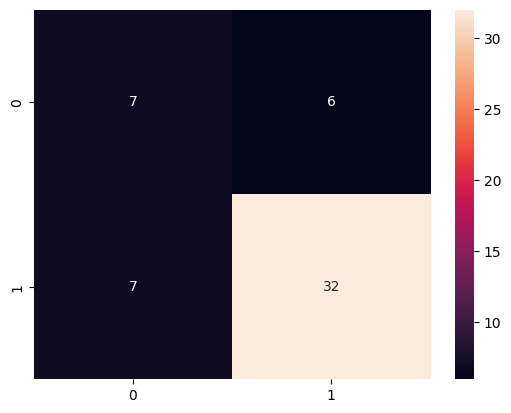

In [40]:
import seaborn as sns
sns.heatmap(cm, annot=True)

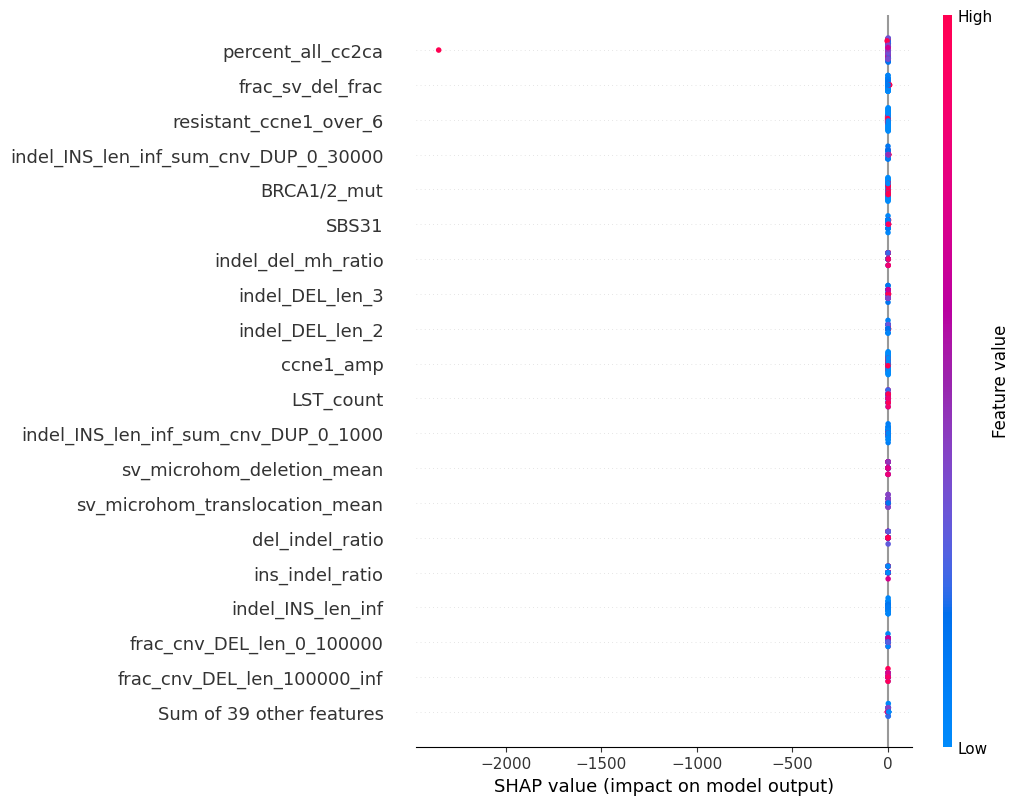

In [41]:
import shap

original_feature_names = ['BRCA1/2_mut', 'other_HRR_gene_mutation_somatic', 'sv_trans_frac', 'sv_del_frac', 'sv_inv_frac', 'sv_tadem_dup_frac', 'sv_n_all_sv', 'sv_n_svclass_stdev', 'sv_microhom_deletion_mean', 'sv_microhom_inversion_mean', 'sv_microhom_tandem-duplication_mean', 'sv_microhom_translocation_mean', 'indel_n_del', 'indel_n_ins', 'ins_indel_ratio', 'del_indel_ratio', 'indel_DEL_len_1', 'indel_DEL_len_2', 'indel_DEL_len_3', 'indel_DEL_len_4', 'indel_DEL_len_inf', 'indel_INS_len_1', 'indel_INS_len_2', 'indel_INS_len_3', 'indel_INS_len_4', 'indel_INS_len_inf', 'indel_DEL_mh', 'indel_DEL_noMHstatus', 'indel_DEL_rep', 'indel_del_mh_ratio', 'Telomeric_AI', 'Interstitial_AI', 'Telomeric_LOH', 'Interstitial_LOH', 'LST_count', 'LOH_count', 'MSI', 'cnv_DEL_0_3500_sum_indel_DEL_len_inf', 'indel_INS_len_inf_sum_cnv_DUP_0_30000', 'indel_INS_len_inf_sum_cnv_DUP_0_1000', 'frac_cnv_DUP_len_30000_inf', 'frac_cnv_DEL_len_100000_inf', 'frac_cnv_DIPLOID_len_100000_inf', 'frac_sv_dup_30000+', 'frac_sv_del_frac', 'frac_sv_del_100000+', 'FBI_relaxed', 'percent_all_cc2ca', 'percent_all_cc2ct', 'cc2ca_vs_cc2ct', 'SBS31', 'ccne1_amp', 'resistant_ccne1_over_6', 'frac_cnv_DUP_len_0_30000', 'frac_cnv_DEL_len_0_100000', 'frac_cnv_DIPLOID_len_0_100000', 'frac_sv_dup_0_30000', 'frac_sv_del_0_100000']
X_train_features = pd.DataFrame(X_train, columns=original_feature_names)
X_test_features = pd.DataFrame(X_test, columns=original_feature_names)

explainer = shap.Explainer(model, X_train_features)
shap_values = explainer(X_test_features)
shap.plots.beeswarm(shap_values, max_display=20)